
The following was adapted from Pytorch's official page under NLP From Scratch: Classifying Names with a Character-Level RNN
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
was created by Sean Robertson <https://github.com/spro/practical-pytorch>
and used under BSD 3-Clause License

-------------------------------------------------------------------------------

BSD 3-Clause License

Copyright (c) 2017-2022, Pytorch contributors
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

-------------------------------------------------------------------------------

Changes (made by Frederick Roman):
- Classified two classes (latin, germanic) instead of many
- Used Tanh for hidden and output
- Tuned hyperparameters

Load dependencies

In [1]:
import torch
import random


Extracting the list of words with latin and germanic etymology.
See get_samples for more info on how these lists were compiled.

In [2]:
from preprocessing.get_samples import latin_list, germanic_list


Showing random samples for latin and germanic etymology lists


In [3]:
print("Latin")
print(random.sample(latin_list, 5))
print("\n")
print("Germanic")
print(random.sample(germanic_list, 5))


Latin
['mirrors', 'prescriptions', 'cajole', 'impious', 'habitats']


Germanic
['goings', 'beavers', 'eleven', 'scuffle', 'fucks']


Computing the set all characters in all words

In [4]:
char_set = set()
words = latin_list + germanic_list
for word in words:
    char_set.update(list(word))
all_char_list = list(char_set)
all_chars = "".join(all_char_list)
n_chars = len(all_char_list)
n_categories = 2
print(all_char_list)

['x', 'u', 'l', 'p', 'f', 'n', 'v', '-', 'g', 'b', 'd', 'm', 'e', 'h', 'z', 'k', 's', 'c', 'o', "'", 'w', 'y', 'i', 'j', 'r', 't', 'q', 'a', '.']


Turn words into tensors

In [5]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_chars.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_chars)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_chars)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('cat'))

print(lineToTensor('cat').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
torch.Size([3, 1, 29])


Creating the network

It's just 2 (linear + tanh) stack layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

In [6]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.tanh =  nn.Tanh() # Added layer on original
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = self.tanh(hidden)
        output = self.i2o(combined)
        output = self.tanh(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 34 * 2
rnn = RNN(n_chars, n_hidden, n_categories)

Getting category with highest likelihood

In [7]:
all_categories =  list([0 for _ in range(0, len(latin_list)) ] +  [1 for _ in range(0, len(germanic_list))])
category_lines = [latin_list, germanic_list]

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


Training the network

In [8]:
criterion = nn.NLLLoss()

learning_rate = 0.005 # Ten times lower than the original

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Getting a random training example

In [9]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([category], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', ["Latin", "Germanic"][category], '/ word =', line)

category = Latin / word = longitudinal
category = Germanic / word = maids
category = Germanic / word = whittle
category = Germanic / word = borns
category = Germanic / word = herder
category = Latin / word = spurious
category = Latin / word = dons
category = Latin / word = venal
category = Latin / word = cowl
category = Latin / word = protuberances


Keeping track of the losses

In [10]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    # print(iter)
    category, line, category_tensor, line_tensor = randomTrainingExample()
    # print(f'category: {category}')
    # print(f'line: {line}')
    # print(f'category_tensor: {category_tensor}')
    # print(f'line_tensor: {line_tensor}')
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 48s) 0.2231 noss / 0 ✗ (1)
10000 10% (1m 50s) 0.1936 hand / 0 ✗ (1)
15000 15% (2m 39s) 0.6460 hatchets / 0 ✗ (1)
20000 20% (3m 24s) 0.2180 spear / 0 ✗ (1)
25000 25% (4m 9s) 0.1832 liquefy / 0 ✓
30000 30% (4m 53s) 0.2591 tides / 0 ✗ (1)
35000 35% (5m 37s) 0.1910 oak / 0 ✗ (1)
40000 40% (6m 21s) 0.1973 fifths / 0 ✗ (1)
45000 45% (7m 7s) 0.1356 incident / 0 ✓
50000 50% (7m 51s) 0.4595 scot / 0 ✗ (1)
55000 55% (8m 42s) 0.1431 pirate / 0 ✓
60000 60% (9m 26s) 0.1331 sausage / 0 ✓
65000 65% (10m 10s) 0.1393 particulates / 0 ✓
70000 70% (10m 51s) 0.2520 sevens / 0 ✗ (1)
75000 75% (11m 42s) 0.1340 billow / 0 ✗ (1)
80000 80% (12m 24s) 0.1305 vineyard / 0 ✓
85000 85% (13m 6s) 0.1334 bites / 0 ✗ (1)
90000 90% (13m 47s) 0.3646 cometh / 0 ✗ (1)
95000 95% (14m 34s) 0.8467 stempel / 0 ✗ (1)
100000 100% (15m 18s) 0.1300 employment / 0 ✓


Plotting the results

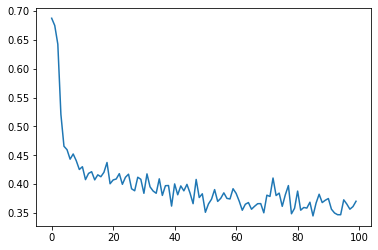

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Running on user input

In [12]:
import math

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=2):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        # print(output)
        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        print(["Latin", "Germanic"][topi[0][0].item()]) 

        for i in range(n_predictions):
            value = math.exp(topv[0][i].item()) 
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])
            
        


predict('let')
predict('throttle')
predict('nationality')
predict('sparkling')
predict('institution')
predict('blind')
predict('wedlock')


> let
Germanic
(0.87) 0
(0.13) 0

> throttle
Germanic
(0.82) 0
(0.18) 0

> nationality
Latin
(0.88) 0
(0.12) 0

> sparkling
Germanic
(0.86) 0
(0.14) 0

> institution
Latin
(0.88) 0
(0.12) 0

> blind
Germanic
(0.87) 0
(0.13) 0

> wedlock
Germanic
(0.88) 0
(0.12) 0


Saving the model

In [13]:
torch.save(rnn.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Evaluating the results

c:\Users\Frederick\miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\Frederick\miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


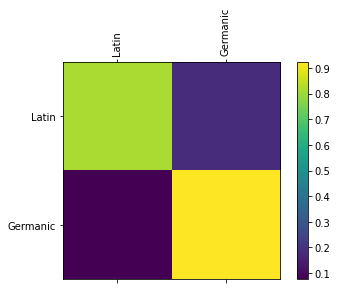

In [14]:
all_categories = [0, 1]

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output


# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels(["", "Latin", "Germanic"], rotation=90)
ax.set_yticklabels(["","Latin", "Germanic"])

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()
